# Machine Learning Models for SCOPE: One-Class SVM
Models will be coded here, but the official write up will be in the RMarkdown document.

In [ ]:
# load the data files
import pandas as pd
import numpy as np
from pymodelutils import utils

logs = pd.read_csv("data/metis_logs.csv")
logs.head()

In [2]:
# filter down to show the average opinion (0 means no alert, 1 means alert)
logs['run_date'] = logs['run_date'].astype('datetime64[ns]')
logs['is_alert'] = (np.where(logs['is_alert'] == 'f', 0, 1))
logs = logs.groupby(['series', 'kpi', 'run_date']).mean().round(0).reset_index()
logs['is_campaign'] = np.where(logs['campaign_id'] > 0, 1, 0)
logs = logs.drop(columns=['client_id', 'partner_id', 'campaign_id'])
logs['is_alert'].describe()

count    9674.000000
mean        0.166425
std         0.372481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_alert, dtype: float64

In [ ]:
AS_data = pd.read_csv("data/python_AS.csv")
AS_data.head()

In [ ]:
TS_data = pd.read_csv("data/python_TS.csv")
TS_data.head()

In [ ]:
RexT_data = pd.read_csv("data/python_RexT.csv")
RexT_data.head()

## Data Prep
R has already filtered down the data to the days we are going to use and marked what is disqualified. We still have to handle the feature selection and one-hot encoding of select columns though. We also need to normalize it since out KPIs behave quite differently.

In [ ]:
# add column for AS to tell if it is campaign level or not
AS_data['is_campaign'] = np.where(AS_data['campaign_id'] > 0, 1, 0)

# drop the data we don't need for the model or for matching back to the logs
AS_keep_columns = ['series', 'day', 'run_date', 'kpi', 'value', 'disqualified', 'is_campaign']
TS_keep_columns = ['series', 'day', 'run_date', 'site_type', 'event_name', 
                   'kpi', 'value', 'disqualified']
RexT_drop_columns = ['ranking',
                    'day_of_week',
                    'day_of_month',
                    'month_of_year',
                    'day_of_year',
                    'week_of_year']

AS_data = AS_data[AS_keep_columns]
TS_data = TS_data[TS_keep_columns]
RexT_data = RexT_data.drop(columns=RexT_drop_columns)

In [ ]:
AS_data.head()

In [ ]:
TS_data.head()

In [ ]:
RexT_data.head()

In [ ]:
# add a new column to determine how many days before the run_date the day column entry is
# this will enable us to pivot that data into separate columns for the features of our model
utils.prep_dates(AS_data)
utils.prep_dates(TS_data)
utils.prep_dates(RexT_data)

In [ ]:
# inner joins to logs
AS_data = pd.merge(AS_data, logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_data = pd.merge(TS_data, logs, on=['series', 'run_date', 'kpi'], how='inner')
RexT_data = pd.merge(RexT_data, logs, on=['series', 'run_date', 'kpi'], how='inner')

In [ ]:
# filter out the disqualified data (AS and TS data only)
AS_disqualified = AS_data[AS_data.disqualified]
TS_disqualified = TS_data[TS_data.disqualified]

# valid for model (AS and TS data only)
valid_AS_raw = AS_data[~(AS_data.disqualified)]
valid_TS_raw = TS_data[~(TS_data.disqualified)]

# keep a copy of the raw RexT data
RexT_data_raw = RexT_data.copy(deep=True)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS = utils.data_prep_pipeline(AS_data.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_TS = utils.data_prep_pipeline(TS_data.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_RexT = utils.data_prep_pipeline(utils.clean_regions(RexT_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'])

In [ ]:
# for the TS data we need to drop event_name_SITE LEVEL because it will always be the same as site_type_SITE LEVEL
valid_TS = {key : value.drop(columns='event_name_SITE LEVEL') for key, value in valid_TS.items()}

In [ ]:
valid_AS['min_max'].head()

In [ ]:
valid_TS['percent_of_mean'].head()

In [ ]:
valid_RexT['standardize'].head()

## Modelling
Now that all the data is prepped, we can start building some logistic regression models to test on. We also need to split our data into a test and train set being careful that we have an equal proportion of anomalies in each (because they are very few, we have to make sure we don't train or test the model on all the anomalies while the other gets none).

### Split Data into Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# scaling method to test
AS_scaler = 'min_max'
TS_scaler = 'min_max'
RexT_scaler = 'min_max'

# separate out data into feature matrices and target arrays
AS_features = valid_AS[AS_scaler][[col for col in valid_AS[AS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]] # this needs to be the model features
AS_targets = valid_AS[AS_scaler]['is_alert'] # this needs to be the results from the logs (only)

TS_features = valid_TS[TS_scaler][[col for col in valid_TS[TS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]]
TS_targets = valid_TS[TS_scaler]['is_alert']

RexT_features = valid_RexT[RexT_scaler][[col for col in valid_RexT[RexT_scaler].columns 
                           if col not in ['run_date', 'is_alert']]]
RexT_targets = valid_RexT[RexT_scaler]['is_alert']
test_RexT_features = RexT_features.drop(columns=[col for col in RexT_features.columns 
                                                 if 'series' in col
                                                or col in ['isCountry', 'isSubregion', 'isRegion']])

# split into a train and test set 
AS_X_train, AS_X_test, AS_y_train, AS_y_test = train_test_split(AS_features[[col for col in AS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                AS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
TS_X_train, TS_X_test, TS_y_train, TS_y_test = train_test_split(TS_features[[col for col in TS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                TS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
RexT_X_train, RexT_X_test, RexT_y_train, RexT_y_test = train_test_split(test_RexT_features[[col for col in 
                                                                                            test_RexT_features.columns
                                                                                            if 'diff' not in col]], 
                                                                        RexT_targets, 
                                                                        test_size=0.5, 
                                                                        random_state=25)

Let's make sure that we have similar percentage of anomalies in our test and train sets. 

In [19]:
# AS
print('Total alerts in training set: ' + str(AS_y_train.sum()))
print('Total alerts in test set: ' + str(AS_y_test.sum()))
pd.DataFrame({'train' : AS_y_train.value_counts(normalize=True), 
              'test' : AS_y_test.value_counts(normalize=True)})

Total alerts in training set: 958.0
Total alerts in test set: 262.0


,test,train
0.0,0.770979,0.790647
1.0,0.229021,0.209353


In [20]:
# TS
print('Total alerts in training set: ' + str(TS_y_train.sum()))
print('Total alerts in test set: ' + str(TS_y_test.sum()))
pd.DataFrame({'train' : TS_y_train.value_counts(normalize=True), 
              'test' : TS_y_test.value_counts(normalize=True)})

Total alerts in training set: 224.0
Total alerts in test set: 76.0


,test,train
0.0,0.891429,0.92
1.0,0.108571,0.08


In [21]:
# RexT
print('Total alerts in training set: ' + str(RexT_y_train.sum()))
print('Total alerts in test set: ' + str(RexT_y_test.sum()))
pd.DataFrame({'train' : RexT_y_train.value_counts(normalize=True), 
              'test' : RexT_y_test.value_counts(normalize=True)})

Total alerts in training set: 9.0
Total alerts in test set: 13.0


,test,train
0.0,0.868687,0.909091
1.0,0.131313,0.090909


## One-Class Support Vector Machine for Anomaly Detection

In [22]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.svm import OneClassSVM

AS_svc = OneClassSVM(random_state=25)
TS_svc = OneClassSVM(random_state=25)
RexT_svc = OneClassSVM(random_state=25)

AS_svc_model = AS_svc.fit(AS_X_train, AS_y_train)
TS_svc_model = TS_svc.fit(TS_X_train, TS_y_train)
RexT_svc_model = RexT_svc.fit(RexT_X_train, RexT_y_train)

In [24]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit = AS_svc_model.decision_function(AS_X_test)
TS_y_prob_fit = TS_svc_model.decision_function(TS_X_test)
RexT_y_prob_fit = RexT_svc_model.decision_function(RexT_X_test)

AS_svc_roc_curve = roc_curve(AS_y_test, AS_y_prob_fit, pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_svc_roc_curve_AUC = auc(AS_svc_roc_curve[0], AS_svc_roc_curve[1]) # needs fpr, tpr
TS_svc_roc_curve = roc_curve(TS_y_test, TS_y_prob_fit, pos_label=1)
TS_svc_roc_curve_AUC = auc(TS_svc_roc_curve[0], TS_svc_roc_curve[1])
RexT_svc_roc_curve = roc_curve(RexT_y_test, RexT_y_prob_fit, pos_label=1)
RexT_svc_roc_curve_AUC = auc(RexT_svc_roc_curve[0], RexT_svc_roc_curve[1])

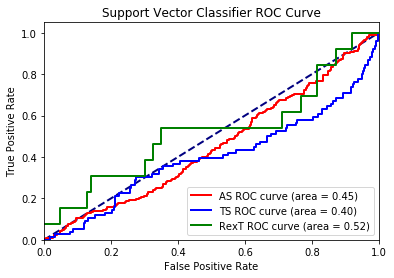

In [25]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_svc_roc_curve, 
                                'TS' : TS_svc_roc_curve, 
                                'RexT' : RexT_svc_roc_curve}, 
                 auc_dict={'AS' : AS_svc_roc_curve_AUC, 
                           'TS' : TS_svc_roc_curve_AUC, 
                           'RexT' : RexT_svc_roc_curve_AUC}, 
                 method_name='Support Vector Classifier')

TP to FP ratio: 0.34


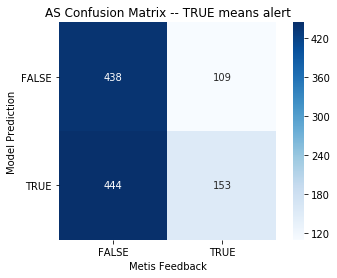

In [33]:
utils.confusion_matrix_visual(AS_y_test, 
                        AS_svc_model.decision_function(AS_X_test) < 0, 'AS') # decision function is negative for outlier

TP to FP ratio: 0.16


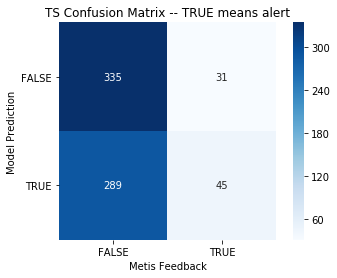

In [34]:
utils.confusion_matrix_visual(TS_y_test, 
                        TS_svc_model.decision_function(TS_X_test) < 0,
                        'TS')

TP to FP ratio: 0.11


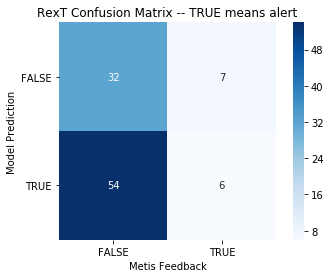

In [35]:
utils.confusion_matrix_visual(RexT_y_test, 
                        RexT_svc_model.decision_function(RexT_X_test) < 0,
                        'RexT')

#### Metrics

In [36]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test, 
                                       'TS' : TS_y_test, 
                                       'RexT' : RexT_y_test},
                         y_pred_dict={'AS' : 
                                      AS_svc_model.decision_function(AS_X_test) < 0, 
                                      'TS' : 
                                      TS_svc_model.decision_function(TS_X_test) < 0, 
                                      'RexT' : 
                                      RexT_svc_model.decision_function(RexT_X_test) < 0})

AS results
             precision    recall  f1-score   support

      False       0.80      0.50      0.61       882
       True       0.26      0.58      0.36       262

avg / total       0.68      0.52      0.55      1144

Percent misclassified: 48.34%
Count misclassified: 553
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.92      0.54      0.68       624
       True       0.13      0.59      0.22        76

avg / total       0.83      0.54      0.63       700

Percent misclassified: 45.71%
Count misclassified: 320
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.82      0.37      0.51        86
       True       0.10      0.46      0.16        13

avg / total       0.73      0.38      0.47        99

Percent misclassified: 61.62%
Count misclassified: 61
